In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import xgboost

pd.set_option('display.max_rows', 150)

In [3]:
seed = 42
np.random.seed(seed)

In [4]:
train_original = pd.read_csv('data/application_train.csv')
# test_original = pd.read_csv('data/application_test.csv')

In [5]:
train_original.shape

(307511, 122)

In [6]:
train_original.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing

In [7]:
# remove columns with more than 100000 missing values
na_sum = train_original.isna().sum().sort_values(ascending=False)
drop_cols = na_sum[na_sum>100000]
train_data = train_original.drop(columns=drop_cols.index)

In [8]:
# drop rows with missing values
train_data.dropna(inplace=True)

# convert object datatype to categorical datatype
train_data[train_data.select_dtypes(['object']).columns] = train_data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

train_data.shape

(167732, 73)

In [9]:
X_train_data, y_train_data = train_data.drop(columns=['SK_ID_CURR', 'TARGET']), train_data['TARGET']

numeric_features = X_train_data.select_dtypes(exclude=['category']).columns
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = X_train_data.select_dtypes(['category']).columns
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [10]:
# train dataset after normalizing and ordinal encoding
X_train_processed = preprocessor.fit_transform(X_train_data)

X = pd.DataFrame(X_train_processed, index=X_train_data.index, columns=X_train_data.columns)


## Feature Selection

In [11]:
feature_selector = SelectKBest(f_classif, k=30)
X_new = feature_selector.fit_transform(X, y_train_data)
X_new.shape

c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [10 33] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\S\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


(167732, 30)

In [12]:
# list of best features selected
feature_selector.get_feature_names_out()

array(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_FAMILY_STATUS',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON'], dtype=object)

## XGBoost Classifier
This is a XGBoost classifier model without removing protected classes and other features highly correlated with them.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_train_data, test_size=0.2, random_state=0)
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)
print("accuracy: %.3f" % xgb_clf.score(X_test, y_test))

accuracy: 0.915


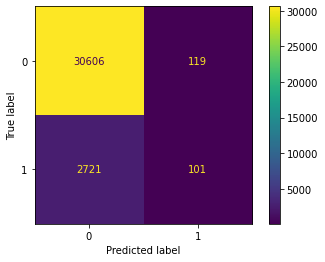

In [14]:
predictions = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

### Using top 30 features

In [15]:
# using top 30 features
X_train, X_test, y_train, y_test = train_test_split(X_new, y_train_data, test_size=0.2, random_state=0)
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)
print("accuracy: %.3f" % xgb_clf.score(X_test, y_test))

accuracy: 0.915


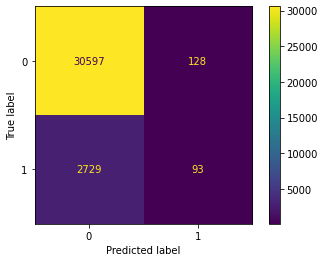

In [16]:
predictions = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

Compared to using all 71 features, using only 30 features has almost no effect on model accuracy but increases both the false positive rate and the false negative rate.

## Imbalanced Data

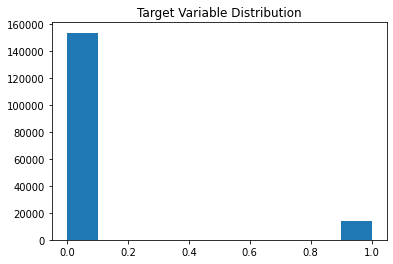

In [17]:
plt.hist(y_train_data)
plt.title('Target Variable Distribution')
plt.show()

In [18]:
y_train_data.value_counts()

0    153525
1     14207
Name: TARGET, dtype: int64

The dataset is imbalanced, as shown above. The class of 1 (default on the loan) makes up less than 10% of the data.

## Principal Component Analysis

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [20]:
X_train_processed.shape

(167732, 71)

In [22]:
pca = PCA()
pca.fit(X_train, y_train)


PCA()

Plot how much orginal variance the decomposition keeps

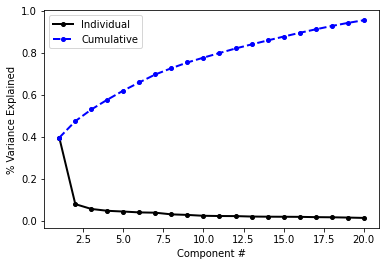

In [23]:
fig=plt.figure(figsize=[6,4])
plt.plot(np.arange(1,21), pca.explained_variance_ratio_[:20],'k.-',lw=2,ms=8,label='Individual')
plt.plot(np.arange(1,21),np.cumsum(pca.explained_variance_ratio_[:20]),'b.--',lw=2,ms=8, label='Cumulative')
plt.legend()
plt.xlabel('Component #')
plt.ylabel('% Variance Explained')
plt.show()

## SHAP Value
SHAP values of a model capture the marginal contribution of each feature to the output and can be used to explain the model.

In [24]:
import shap

from interpret import show
from interpret.blackbox import ShapKernel
from interpret.blackbox import PartialDependence

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [27]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)
pdp = PartialDependence(xgb_clf, X_train)

In [28]:
show(pdp.explain_global(), 0)

In [29]:
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=3, tree_method='hist', enable_categorical=True).fit(X_train, y_train)

X100 = shap.utils.sample(X_train, 100)  # 100 instances for use as the background distribution
sample_ind = 20

# explain the model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X_train)


100%|===================| 134163/134185 [08:39<00:00]        